In [2]:
import torch

print("PyTorch version:", torch.__version__)
print("MPS disponible:", torch.backends.mps.is_available())
print("MPS construit:", torch.backends.mps.is_built())

if torch.backends.mps.is_available():
    device = torch.device("mps")
    x = torch.randn(1000, 1000).to(device)
    print("Test MPS réussi!")

PyTorch version: 2.8.0
MPS disponible: True
MPS construit: True
Test MPS réussi!


In [2]:
import torch
torch.backends.mps.is_available()
torch.backends.mps.is_built()  # Pour voir si MPS a été compilé

True

In [2]:
!python3 --version

Python 3.9.6


In [4]:
import tensorflow as tf
# import keras
import h5py
import numpy as np
import scipy

print("TensorFlow:", tf.__version__)
# print("Keras:", keras.__version__)
print("h5py:", h5py.__version__)
print("NumPy:", np.__version__)
print("SciPy:", scipy.__version__)


TensorFlow: 2.19.0
h5py: 3.13.0
NumPy: 2.0.2
SciPy: 1.13.1


In [1]:
from scipy import interpolate

def spline_up(x_lr, r):
    """ Interpolation par splines cubiques pour le pré-traitement"""
    x_lr = x_lr.flatten() # Assurez-vous que x_lr est un tableau 1D
    x_hr_len = len(x_lr) * r # r est le factor de sur-échantillonnage, le high-res sera r fois plus long que le low-res
    x_sp = np.zeros(x_hr_len) 
    i_lr = np.arange(x_hr_len, step=r) # Indices du low-res
    i_hr = np.arange(x_hr_len) # Indices du high-res, indices à interpoler
    f = interpolate.splrep(i_lr, x_lr)
    x_sp = interpolate.splev(i_hr, f) # Interpolation spline
    return x_sp

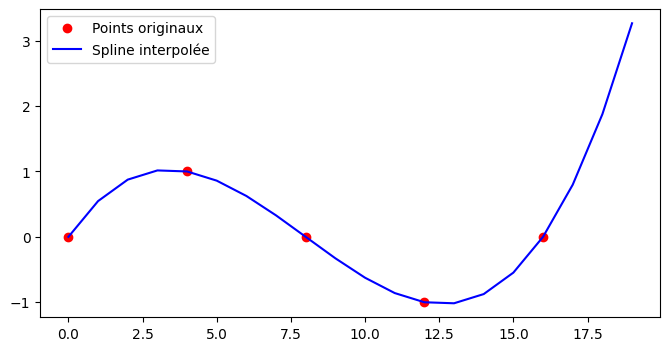

In [2]:
import numpy as np
from scipy import interpolate
import matplotlib.pyplot as plt

# Signal basse résolution
x_lr = np.array([0, 1, 0, -1, 0])  
r = 4

x_sp = spline_up(x_lr, r)

# Affichage
plt.figure(figsize=(8,4))
plt.plot(np.arange(len(x_lr))*r, x_lr, "ro", label="Points originaux")
plt.plot(x_sp, "b-", label="Spline interpolée")
plt.legend()
plt.show()


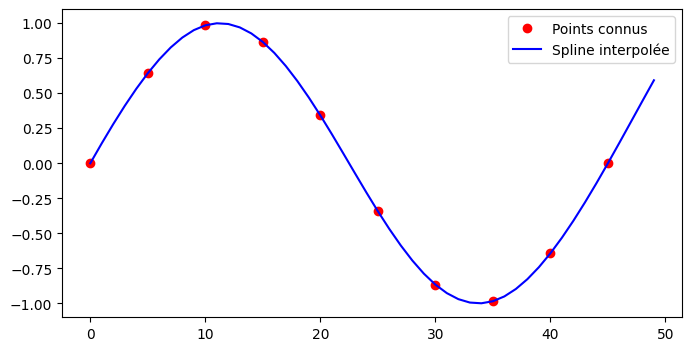

In [3]:
# Signal basse résolution : sinus
t = np.linspace(0, 2*np.pi, 10)
x_lr = np.sin(t)

x_sp = spline_up(x_lr, r=5)

plt.figure(figsize=(8,4))
plt.plot(np.arange(len(x_lr))*5, x_lr, "ro", label="Points connus")
plt.plot(x_sp, "b-", label="Spline interpolée")
plt.legend()
plt.show()

In [1]:
import os
import random
import torch
import torchaudio
import numpy as np
from collections import defaultdict
from torch.utils.data import Dataset, DataLoader
import json
from pathlib import Path

class VCTKSplitter:
    def __init__(self, vctk_path, seed=42):
        self.vctk_path = Path(vctk_path)
        self.seed = seed
        random.seed(seed)
        np.random.seed(seed)
        
    def analyze_speakers(self):
        """Analyse les caractéristiques des locuteurs pour un split intelligent"""
        speakers_info = defaultdict(lambda: {'files': [], 'total_duration': 0})
        
        # Scanner tous les fichiers audio
        audio_files = list(self.vctk_path.glob('*.wav'))
        
        for file_path in audio_files:
            speaker_id = file_path.stem.split('_')[0]  # p225_001.wav -> p225
            speakers_info[speaker_id]['files'].append(str(file_path))
            
            # Optionnel: calculer la durée pour un split plus équilibré
            try:
                waveform, sample_rate = torchaudio.load(file_path)
                duration = waveform.shape[1] / sample_rate
                speakers_info[speaker_id]['total_duration'] += duration
            except:
                # Si erreur de lecture, estimer durée moyenne
                speakers_info[speaker_id]['total_duration'] += 3.0
        
        return dict(speakers_info)
    
    def create_splits(self, num_train_blocks=16, val_ratio=0.05, test_ratio=0.05):
        """
        Crée les splits recommandés:
        - 16 blocs d'entraînement par locuteurs
        - 1 set de validation stratifié constant  
        - 1 set de test
        """
        speakers_info = self.analyze_speakers()
        all_speakers = list(speakers_info.keys())
        total_speakers = len(all_speakers)
        
        print(f"Total speakers found: {total_speakers}")
        
        # Calculer les tailles
        num_test = max(1, int(total_speakers * test_ratio))
        num_val = max(1, int(total_speakers * val_ratio))
        num_train = total_speakers - num_test - num_val
        
        print(f"Split: {num_train} train, {num_val} val, {num_test} test speakers")
        
        # Mélanger et diviser
        random.shuffle(all_speakers)
        
        test_speakers = all_speakers[:num_test]
        val_speakers = all_speakers[num_test:num_test + num_val]
        train_speakers = all_speakers[num_test + num_val:]
        
        # Créer les blocs d'entraînement
        speakers_per_block = len(train_speakers) // num_train_blocks
        train_blocks = []
        
        for i in range(num_train_blocks):
            start_idx = i * speakers_per_block
            end_idx = (i + 1) * speakers_per_block if i < num_train_blocks - 1 else len(train_speakers)
            
            block_speakers = train_speakers[start_idx:end_idx]
            block_files = []
            
            for speaker in block_speakers:
                block_files.extend(speakers_info[speaker]['files'])
            
            train_blocks.append({
                'speakers': block_speakers,
                'files': block_files,
                'num_files': len(block_files)
            })
            
            print(f"Block {i+1}: {len(block_speakers)} speakers, {len(block_files)} files")
        
        # Créer sets de validation et test
        val_files = []
        for speaker in val_speakers:
            val_files.extend(speakers_info[speaker]['files'])
            
        test_files = []
        for speaker in test_speakers:
            test_files.extend(speakers_info[speaker]['files'])
        
        splits = {
            'train_blocks': train_blocks,
            'val': {
                'speakers': val_speakers,
                'files': val_files,
                'num_files': len(val_files)
            },
            'test': {
                'speakers': test_speakers,
                'files': test_files,
                'num_files': len(test_files)
            }
        }
        
        return splits
    
    def save_splits(self, splits, save_path="./data_splits.json"):
        """Sauvegarde les splits pour reproductibilité"""
        with open(save_path, 'w') as f:
            json.dump(splits, f, indent=2)
        print(f"Splits saved to {save_path}")
    
    def load_splits(self, load_path="./data_splits.json"):
        """Charge des splits sauvegardés"""
        with open(load_path, 'r') as f:
            return json.load(f)

In [2]:
path = "/Users/rovafifaliana/.cache/kagglehub/datasets/awsaf49/vctk-sr16k-dataset/versions/1/wavs"
print("Path to VCTK dataset:", path)

Path to VCTK dataset: /Users/rovafifaliana/.cache/kagglehub/datasets/awsaf49/vctk-sr16k-dataset/versions/1/wavs


In [9]:
vctk_path = path  # Modifier ce chemin
splitter = VCTKSplitter(vctk_path)

print("Creating data splits...")
splits = splitter.create_splits(num_train_blocks=16, val_ratio=(0.05/2), test_ratio=0.05)
splitter.save_splits(splits)

Creating data splits...
Total speakers found: 108
Split: 101 train, 2 val, 5 test speakers
Block 1: 6 speakers, 2241 files
Block 2: 6 speakers, 2096 files
Block 3: 6 speakers, 2634 files
Block 4: 6 speakers, 2151 files
Block 5: 6 speakers, 2554 files
Block 6: 6 speakers, 2383 files
Block 7: 6 speakers, 2442 files
Block 8: 6 speakers, 2525 files
Block 9: 6 speakers, 2576 files
Block 10: 6 speakers, 2340 files
Block 11: 6 speakers, 2512 files
Block 12: 6 speakers, 2544 files
Block 13: 6 speakers, 2404 files
Block 14: 6 speakers, 2430 files
Block 15: 6 speakers, 2497 files
Block 16: 11 speakers, 4540 files
Splits saved to ./data_splits.json


In [5]:
import kagglehub

# Download latest version
path = kagglehub.dataset_download("awsaf49/vctk-sr16k-dataset")

print("Path to dataset files:", path)

Resuming download from 2245001216 bytes (1040466703 bytes left)...
Resuming download from https://www.kaggle.com/api/v1/datasets/download/awsaf49/vctk-sr16k-dataset?dataset_version_number=1 (2245001216/3285467919) bytes left.


100%|██████████| 3.06G/3.06G [14:53<00:00, 1.16MB/s]

Extracting files...


Path to dataset files: /Users/rovafifaliana/.cache/kagglehub/datasets/awsaf49/vctk-sr16k-dataset/versions/1


In [7]:
993 / 163

6.0920245398773005

In [5]:
1 - 0.07

0.9299999999999999

In [6]:
((1 - 0.07) * 20) / 100

0.18599999999999997

In [3]:
model_path = "model_afilm_single_2.pth_epoch10.pth"
val_data_path = "vctk_single_dataset/test281.h5"
model_type = "afilm"
layers = 4
scale = 2

In [4]:
# Setup device
if torch.backends.mps.is_available():
    device = torch.device("mps")
elif torch.cuda.is_available():
    device = torch.device("cuda")
else:
    device = torch.device("cpu")

print(f"Using device: {device}")

Using device: mps


In [13]:
import sys

sys.path.append("/Users/rovafifaliana/Documents/MISA/machine_learning/evaluation2/AFiLM_conversion/codes")
print (sys.path)

['/Users/rovafifaliana/.pyenv/versions/3.10.14/lib/python310.zip', '/Users/rovafifaliana/.pyenv/versions/3.10.14/lib/python3.10', '/Users/rovafifaliana/.pyenv/versions/3.10.14/lib/python3.10/lib-dynload', '', '/Users/rovafifaliana/.pyenv/versions/afilm_env/lib/python3.10/site-packages', '/Users/rovafifaliana/Documents/MISA/machine_learning/evaluation2/AFiLM_conversion/', '/Users/rovafifaliana/Documents/MISA/machine_learning/evaluation2/AFiLM_conversion/codes', '/Users/rovafifaliana/Documents/MISA/machine_learning/evaluation2/AFiLM_conversion/codes']


In [14]:
from models.afilm import get_afilm
from models.tfilm import get_tfilm

# Load model
if model_type == 'afilm':
    model = get_afilm(n_layers=layers, scale=scale)
elif model_type == 'tfilm':
    model = get_tfilm(n_layers=layers, scale=scale)
else:
    raise ValueError(f"Unknown model type: {model_type}")

In [16]:
model.load_state_dict(torch.load(model_path, map_location=device))
model.to(device)
model.eval()

AFiLMNet(
  (down_blocks): ModuleList(
    (0): Conv1d(1, 128, kernel_size=(65,), stride=(1,), padding=same, dilation=(2,))
    (1): Conv1d(128, 256, kernel_size=(33,), stride=(1,), padding=same, dilation=(2,))
    (2): Conv1d(256, 512, kernel_size=(17,), stride=(1,), padding=same, dilation=(2,))
    (3): Conv1d(512, 512, kernel_size=(9,), stride=(1,), padding=same, dilation=(2,))
  )
  (bottleneck_conv): Conv1d(512, 512, kernel_size=(9,), stride=(1,), padding=same, dilation=(2,))
  (up_blocks): ModuleList(
    (0): Conv1d(768, 512, kernel_size=(9,), stride=(1,), padding=same, dilation=(2,))
    (1): Conv1d(768, 512, kernel_size=(17,), stride=(1,), padding=same, dilation=(2,))
    (2): Conv1d(512, 256, kernel_size=(33,), stride=(1,), padding=same, dilation=(2,))
    (3): Conv1d(256, 128, kernel_size=(65,), stride=(1,), padding=same, dilation=(2,))
  )
  (out_conv): Conv1d(128, 2, kernel_size=(9,), stride=(1,), padding=(4,))
)

In [17]:
import torch.nn as nn

# Evaluate
criterion = nn.MSELoss()
total_loss = 0.0
num_samples = 0

In [19]:
import h5py

print("Loading validation data...")
with h5py.File(val_data_path, "r") as f:
    X_val = torch.tensor(f["X"][:], dtype=torch.float32)
    Y_val = torch.tensor(f["Y"][:], dtype=torch.float32)

    print(f"Validation data shape: X={X_val.shape}, Y={Y_val.shape}")

Loading validation data...
Validation data shape: X=torch.Size([1166, 1024]), Y=torch.Size([1166, 1024])


In [20]:
from torch.utils.data import TensorDataset, DataLoader

val_loader = DataLoader(TensorDataset(X_val, Y_val), batch_size=16)

print("Evaluating...")
with torch.no_grad():
    for X, Y in val_loader:
        X, Y = X.to(device), Y.to(device)
        outputs = model(X)

        print(f"Output shape: {outputs.shape}, Target shape: {Y.shape}")
        print(f"Outputs.dim(): {outputs.dim()}, Outputs.shape: {outputs.shape}")
        
        # Handle potential shape issues (same as in your training script)
        if outputs.dim() == 3 and outputs.shape[-1] == 2:
            print("Condition vérifiée")
            outputs = outputs[:, :, 0]
        
        loss = criterion(outputs, Y)
        total_loss += loss.item() * X.size(0)
        num_samples += X.size(0)

Evaluating...
Output shape: torch.Size([16, 1024]), Target shape: torch.Size([16, 1024])
Outputs.dim(): 2, Outputs.shape: torch.Size([16, 1024])
Output shape: torch.Size([16, 1024]), Target shape: torch.Size([16, 1024])
Outputs.dim(): 2, Outputs.shape: torch.Size([16, 1024])
Output shape: torch.Size([16, 1024]), Target shape: torch.Size([16, 1024])
Outputs.dim(): 2, Outputs.shape: torch.Size([16, 1024])
Output shape: torch.Size([16, 1024]), Target shape: torch.Size([16, 1024])
Outputs.dim(): 2, Outputs.shape: torch.Size([16, 1024])
Output shape: torch.Size([16, 1024]), Target shape: torch.Size([16, 1024])
Outputs.dim(): 2, Outputs.shape: torch.Size([16, 1024])
Output shape: torch.Size([16, 1024]), Target shape: torch.Size([16, 1024])
Outputs.dim(): 2, Outputs.shape: torch.Size([16, 1024])
Output shape: torch.Size([16, 1024]), Target shape: torch.Size([16, 1024])
Outputs.dim(): 2, Outputs.shape: torch.Size([16, 1024])
Output shape: torch.Size([16, 1024]), Target shape: torch.Size([16, 1

In [21]:
avg_loss = total_loss / num_samples
print(f"Validation Loss: {avg_loss:.6f}")

Validation Loss: 0.000392


## Display x2

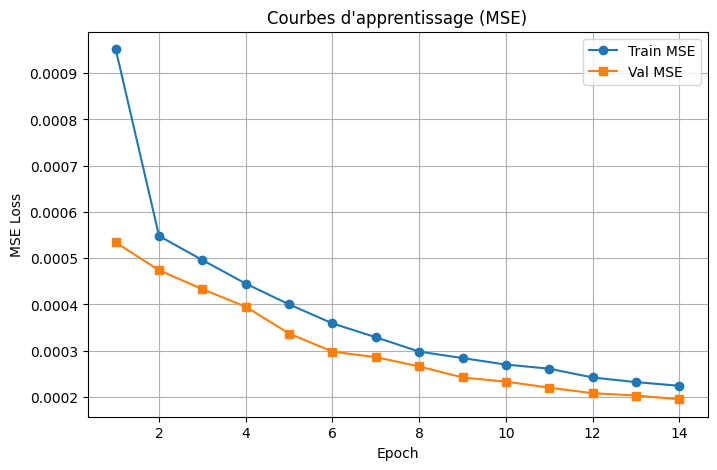

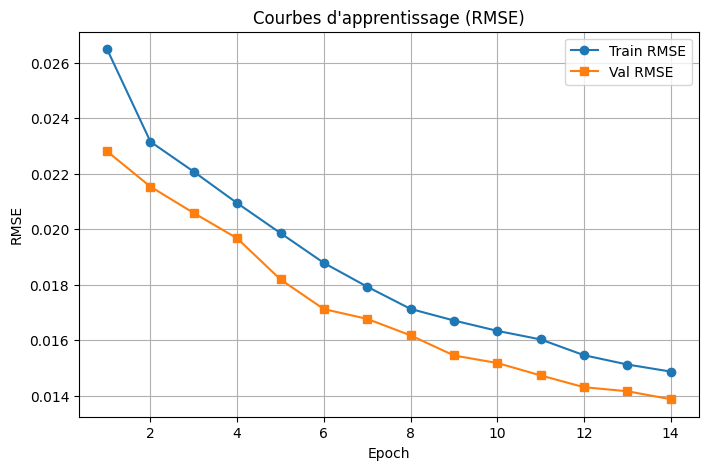

In [1]:
import matplotlib.pyplot as plt

# Données extraites du log
epochs = list(range(1, 15))

train_mse = [
    0.000952, 0.000548, 0.000496, 0.000445, 0.000400,
    0.000359, 0.000329, 0.000298, 0.000284, 0.000270,
    0.000261, 0.000242, 0.000232, 0.000224
]

val_mse = [
    0.000534, 0.000474, 0.000433, 0.000395, 0.000337,
    0.000298, 0.000286, 0.000266, 0.000242, 0.000233,
    0.000220, 0.000208, 0.000203, 0.000195
]

train_rmse = [
    0.026487, 0.023154, 0.022072, 0.020941, 0.019859,
    0.018785, 0.017927, 0.017127, 0.016710, 0.016337,
    0.016028, 0.015459, 0.015124, 0.014869
]

val_rmse = [
    0.022807, 0.021534, 0.020583, 0.019672, 0.018188,
    0.017121, 0.016768, 0.016174, 0.015449, 0.015178,
    0.014731, 0.014306, 0.014160, 0.013873
]

# Tracé MSE
plt.figure(figsize=(8,5))
plt.plot(epochs, train_mse, marker='o', label="Train MSE")
plt.plot(epochs, val_mse, marker='s', label="Val MSE")
plt.xlabel("Epoch")
plt.ylabel("MSE Loss")
plt.title("Courbes d'apprentissage (MSE)")
plt.legend()
plt.grid(True)
plt.show()

# Tracé RMSE
plt.figure(figsize=(8,5))
plt.plot(epochs, train_rmse, marker='o', label="Train RMSE")
plt.plot(epochs, val_rmse, marker='s', label="Val RMSE")
plt.xlabel("Epoch")
plt.ylabel("RMSE")
plt.title("Courbes d'apprentissage (RMSE)")
plt.legend()
plt.grid(True)
plt.show()


## Display x4

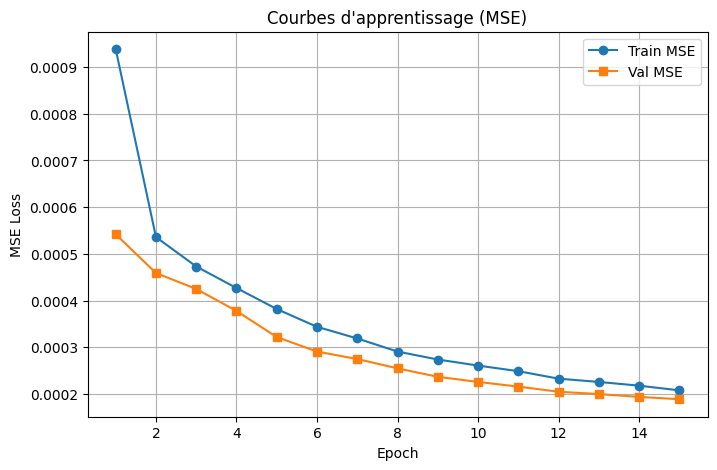

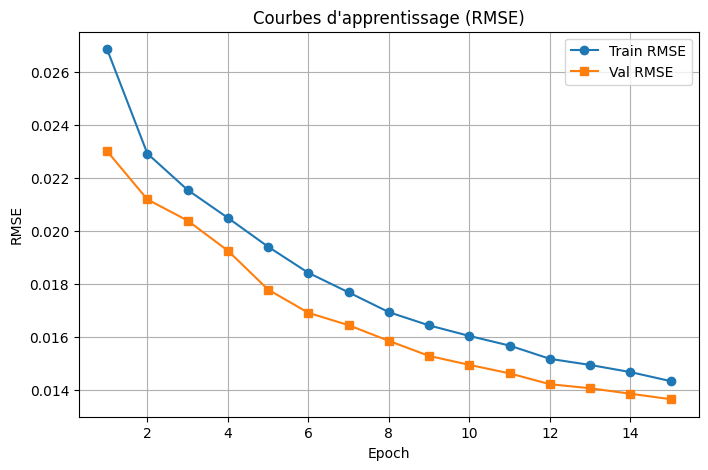

In [3]:
import matplotlib.pyplot as plt

epochs = list(range(1, 16))

train_mse = [
    0.000938, 0.000536, 0.000473, 0.000427, 0.000382,
    0.000344, 0.000319, 0.000291, 0.000274, 0.000261,
    0.000249, 0.000233, 0.000226, 0.000218, 0.000208
]

val_mse = [
    0.000542, 0.000459, 0.000425, 0.000378, 0.000322,
    0.000291, 0.000275, 0.000255, 0.000237, 0.000226,
    0.000216, 0.000205, 0.000200, 0.000194, 0.000189
]

train_rmse = [
    0.026847, 0.022911, 0.021538, 0.020485, 0.019395,
    0.018410, 0.017673, 0.016926, 0.016427, 0.016029,
    0.015664, 0.015165, 0.014935, 0.014665, 0.014325
]

val_rmse = [
    0.023001, 0.021181, 0.020382, 0.019247, 0.017778,
    0.016902, 0.016435, 0.015843, 0.015274, 0.014938,
    0.014617, 0.014208, 0.014056, 0.013849, 0.013642
]

# Tracé MSE
plt.figure(figsize=(8,5))
plt.plot(epochs, train_mse, marker='o', label="Train MSE")
plt.plot(epochs, val_mse, marker='s', label="Val MSE")
plt.xlabel("Epoch")
plt.ylabel("MSE Loss")
plt.title("Courbes d'apprentissage (MSE)")
plt.legend()
plt.grid(True)
plt.show()

# Tracé RMSE
plt.figure(figsize=(8,5))
plt.plot(epochs, train_rmse, marker='o', label="Train RMSE")
plt.plot(epochs, val_rmse, marker='s', label="Val RMSE")
plt.xlabel("Epoch")
plt.ylabel("RMSE")
plt.title("Courbes d'apprentissage (RMSE)")
plt.legend()
plt.grid(True)
plt.show()

## Display x8

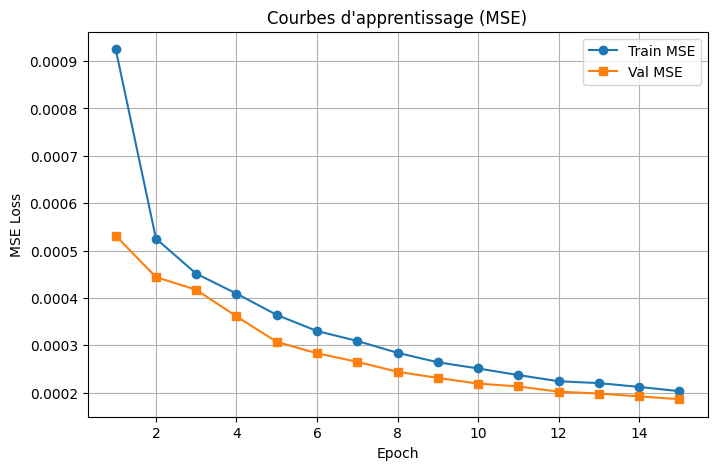

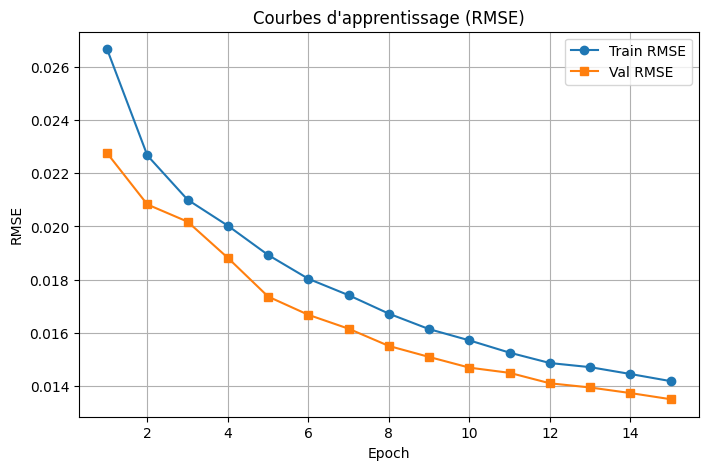

In [2]:
import matplotlib.pyplot as plt

# Données extraites du log
epochs = list(range(1, 16))

train_mse = [
    0.000925, 0.000525, 0.000451, 0.000409, 0.000364,
    0.000330, 0.000309, 0.000284, 0.000264, 0.000251,
    0.000237, 0.000224, 0.000220, 0.000212, 0.000203
]

val_mse = [
    0.000531, 0.000444, 0.000417, 0.000361, 0.000307,
    0.000283, 0.000265, 0.000244, 0.000231, 0.000219,
    0.000213, 0.000202, 0.000198, 0.000192, 0.000186
]

train_rmse = [
    0.026658, 0.022668, 0.021005, 0.020029, 0.018930,
    0.018035, 0.017419, 0.016725, 0.016144, 0.015722,
    0.015260, 0.014871, 0.014716, 0.014459, 0.014191
]

val_rmse = [
    0.022756, 0.020827, 0.020180, 0.018821, 0.017367,
    0.016682, 0.016160, 0.015512, 0.015099, 0.014698,
    0.014502, 0.014110, 0.013953, 0.013743, 0.013512
]

# Tracé MSE
plt.figure(figsize=(8,5))
plt.plot(epochs, train_mse, marker='o', label="Train MSE")
plt.plot(epochs, val_mse, marker='s', label="Val MSE")
plt.xlabel("Epoch")
plt.ylabel("MSE Loss")
plt.title("Courbes d'apprentissage (MSE)")
plt.legend()
plt.grid(True)
plt.show()

# Tracé RMSE
plt.figure(figsize=(8,5))
plt.plot(epochs, train_rmse, marker='o', label="Train RMSE")
plt.plot(epochs, val_rmse, marker='s', label="Val RMSE")
plt.xlabel("Epoch")
plt.ylabel("RMSE")
plt.title("Courbes d'apprentissage (RMSE)")
plt.legend()
plt.grid(True)
plt.show()
